In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import requests
import io

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

model.to('cuda')
model.eval()

In [ ]:
imgs = ['http://images.cocodataset.org/val2017/000000514979.jpg',
        'http://images.cocodataset.org/val2017/000000166259.jpg',
        'http://images.cocodataset.org/val2017/000000163257.jpg',
        'http://images.cocodataset.org/val2017/000000031093.jpg'
]

In [ ]:
def prepare_input(img_url):

    response = requests.get(img_url)
    img = Image.open(io.BytesIO(response.content))

    img = img.convert('RGB')

    img = img.resize((300, 300))

    # normalize
    img = np.array(img) / 255.0

    # HWC to CHW 
    img = np.moveaxis(img, -1, 0)

    img = torch.from_numpy(img).float()

    return img

In [ ]:
def prepare_tensor(inputs):
  
    tensor = torch.stack(inputs, dim=0)

    if torch.cuda.is_available():
        tensor = tensor.to('cuda')

    return tensor

In [ ]:
inputs = [prepare_input(img) for img in imgs]
tensor = prepare_tensor(inputs)

In [ ]:
with torch.no_grad():
    detect = model(tensor)

In [ ]:
results = utils.decode_results(detect)
best_results = [utils.pick_best(res, 0.50) for res in results]

classes_to_labels = utils.get_coco_object_dictionary()

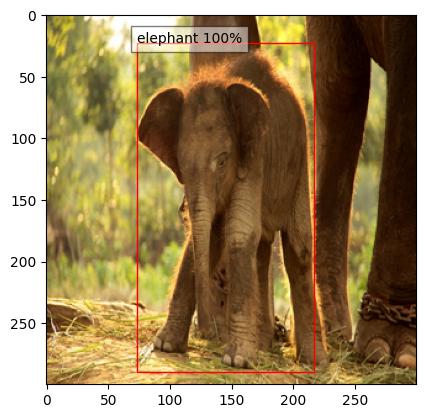

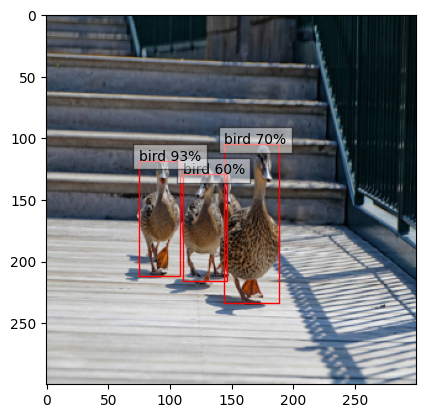

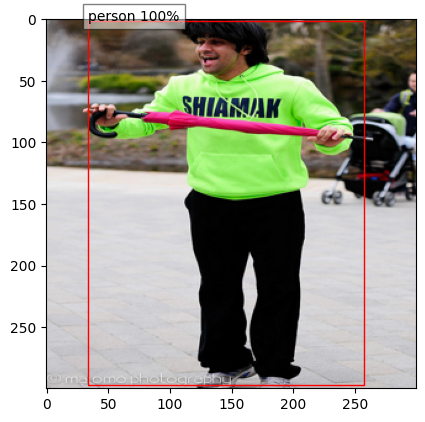

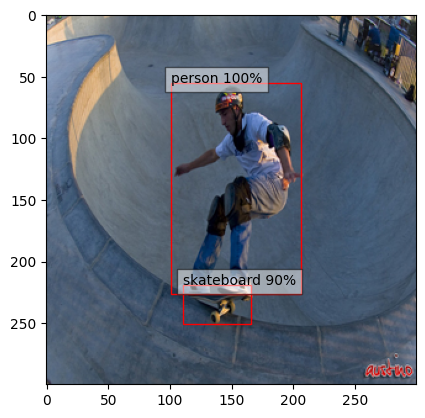

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results)):
    fig, ax = plt.subplots(1)
    
    image = inputs[image_idx].clone().detach()
    image = torch.transpose(image, 0, 1)
    image = torch.transpose(image, 1, 2)
    
    ax.imshow(image)
    
    bboxes, classes, confidences = best_results[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
        
plt.show()